In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
train_data = pd.read_csv('./Data/train.csv').dropna()
test_data = pd.read_csv('./Data/test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [5]:
input_features = train_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Cabin']].replace(['female', 'male'], [0,1])
output_features = train_data['Survived']

In [6]:
binary_feature_names = ['Sex']
numeric_feature_names = ['Pclass', 'Age', 'SibSp', 'Parch']
numeric_feature = input_features[numeric_feature_names]

# Input vector

In [7]:
inputs = {}

for name, column in input_features.items():
    if name in binary_feature_names:
        dtype = tf.int64
    elif input_features[name].dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(
      shape=(), name=name, dtype=dtype)

inputs

{'Pclass': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'Pclass')>,
 'Sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'Sex')>,
 'Age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'Age')>,
 'SibSp': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'SibSp')>,
 'Parch': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'Parch')>,
 'Cabin': <KerasTensor: shape=(None,) dtype=string (created by layer 'Cabin')>}

# Preprocessing
Unpack each row as one data sample using tf.stack.
Convert the list of tensor into a tensor with rank one higher than each tensor

In [8]:
def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
      values.append(tf.cast(inputs[key], tf.float32))

    return fun(values, axis=-1)

In [9]:
preprocessed = []
for feature_name in binary_feature_names:
    temp = inputs[feature_name]
    temp = tf.expand_dims(temp, axis=1)
    temp_float = tf.cast(temp, tf.float32)
    preprocessed.append(temp_float)

preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast')>]

In [10]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_feature)))

In [11]:
numeric_inputs = {}
for name in numeric_feature_names:
  numeric_inputs[name]=inputs[name]

numeric_inputs = stack_dict(numeric_inputs)
numeric_normalized = normalizer(numeric_inputs)

preprocessed.append(numeric_normalized)

preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'normalization')>]

In [12]:
preprocesssed_result = tf.concat(preprocessed, axis=-1)
preprocesssed_result

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'tf.concat')>

In [13]:
preprocessor = tf.keras.Model(inputs, preprocesssed_result)

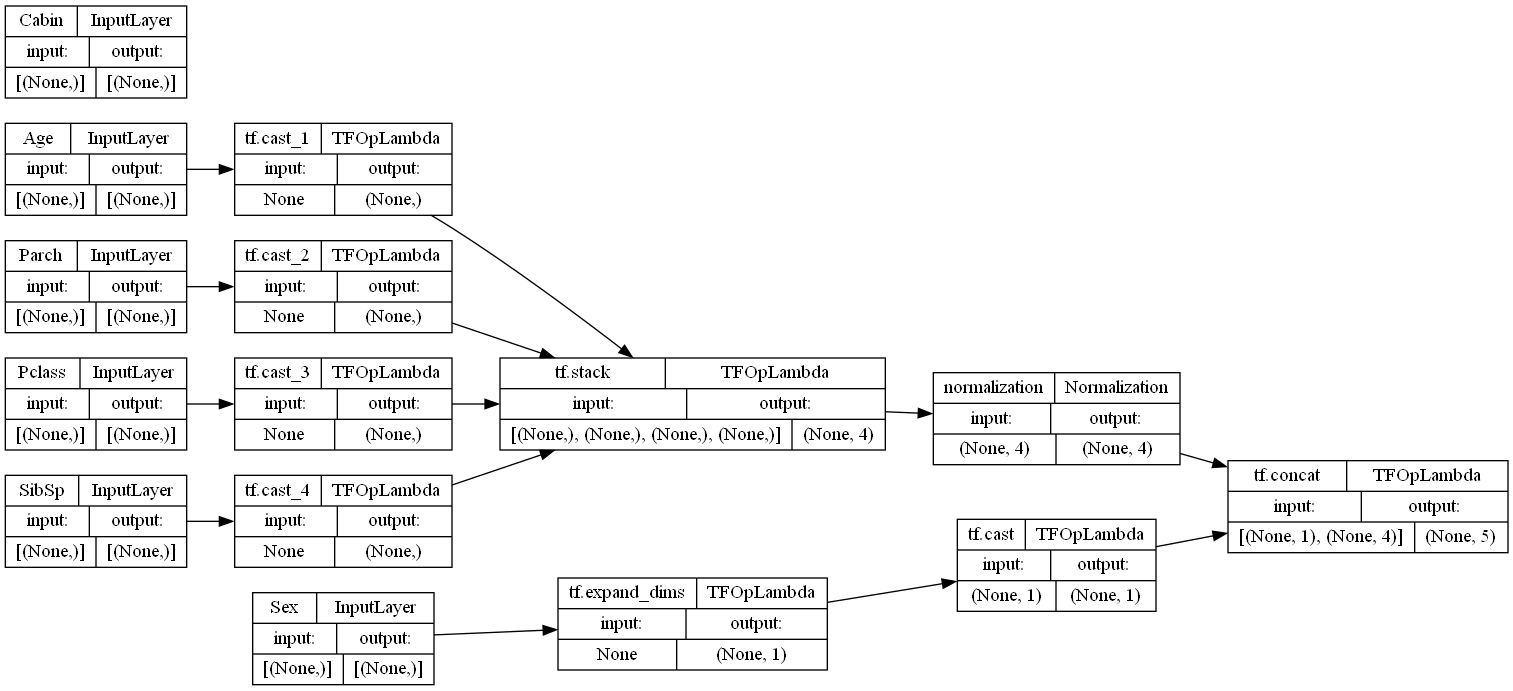

In [14]:
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)

In [15]:
preprocessor(dict(input_features.iloc[:1]))

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 0.        ,  0.14906502, -0.6317298 , -0.37225628,  0.8336275 ]],
      dtype=float32)>

# Build Model

In [16]:
body = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

In [17]:
inputs

{'Pclass': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'Pclass')>,
 'Sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'Sex')>,
 'Age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'Age')>,
 'SibSp': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'SibSp')>,
 'Parch': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'Parch')>,
 'Cabin': <KerasTensor: shape=(None,) dtype=string (created by layer 'Cabin')>}

In [18]:
x = preprocessor(inputs)
x

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'model')>

In [19]:
result = body(x)
result

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sequential')>

In [20]:
model = tf.keras.Model(inputs, result)

model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Age (InputLayer)               [(None,)]            0           []                               
                                                                                                  
 Cabin (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 Parch (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 Pclass (InputLayer)            [(None,)]            0           []                               
                                                                                            

In [24]:
ds = tf.data.Dataset.from_tensor_slices((
    dict(input_features),
    output_features
))
BATCH_SIZE=8
ds = ds.batch(BATCH_SIZE)

In [25]:
import pprint

for x, y in ds.take(1):
  pprint.pprint(x)
  print()
  print(y)

{'Age': <tf.Tensor: shape=(8,), dtype=float64, numpy=array([38., 35., 54.,  4., 58., 34., 28., 19.])>,
 'Cabin': <tf.Tensor: shape=(8,), dtype=string, numpy=
array([b'C85', b'C123', b'E46', b'G6', b'C103', b'D56', b'A6',
       b'C23 C25 C27'], dtype=object)>,
 'Parch': <tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 0, 0, 1, 0, 0, 0, 2], dtype=int64)>,
 'Pclass': <tf.Tensor: shape=(8,), dtype=int64, numpy=array([1, 1, 1, 3, 1, 2, 1, 1], dtype=int64)>,
 'Sex': <tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 0, 1, 0, 0, 1, 1, 1], dtype=int64)>,
 'SibSp': <tf.Tensor: shape=(8,), dtype=int64, numpy=array([1, 1, 0, 1, 0, 0, 0, 3], dtype=int64)>}

tf.Tensor([1 1 0 1 1 1 1 0], shape=(8,), dtype=int64)


In [26]:
history = model.fit(ds, epochs=128)

Epoch 1/128
23/23 [==============================] - 0s 1ms/step - loss: 0.6644 - accuracy: 0.4044
Epoch 2/128
23/23 [==============================] - 0s 1000us/step - loss: 0.6517 - accuracy: 0.4153
Epoch 3/128
23/23 [==============================] - 0s 981us/step - loss: 0.6401 - accuracy: 0.4754
Epoch 4/128
23/23 [==============================] - 0s 954us/step - loss: 0.6284 - accuracy: 0.4809
Epoch 5/128
23/23 [==============================] - 0s 954us/step - loss: 0.6172 - accuracy: 0.4973
Epoch 6/128
23/23 [==============================] - 0s 963us/step - loss: 0.6056 - accuracy: 0.5519
Epoch 7/128
23/23 [==============================] - 0s 916us/step - loss: 0.5947 - accuracy: 0.6175
Epoch 8/128
23/23 [==============================] - 0s 954us/step - loss: 0.5839 - accuracy: 0.6885
Epoch 9/128
23/23 [==============================] - 0s 1ms/step - loss: 0.5729 - accuracy: 0.7213
Epoch 10/128
23/23 [==============================] - 0s 1000us/step - loss: 0.5624 - accuracy